# Aluna: Alana Viana
# Tarefa Análise de Votos

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [210]:
# dados de 2006
df = pd.read_csv("data/eleicoes_2006_a_2010.csv")
train = df[(df["ano"]==2006)]
train = train.drop(columns=["ano"])
train = train.drop(columns=["sequencial_candidato"])
train = train.drop(columns=["nome"])

# dados de 2010
test = df[(df["ano"]==2010)]
test = test.drop(columns=["ano"])
test = test.drop(columns=["sequencial_candidato"])
test = test.drop(columns=["nome"])

# dados de 2006 e 2010
all_data = pd.concat([train, test])

# dados de 2014
df_2014 = pd.read_csv("data/eleicoes_2014.csv")
test_all = df_2014
test_all = test_all.drop(columns=["ano"])
test_all = test_all.drop(columns=["sequencial_candidato"])
test_all = test_all.drop(columns=["nome"])

## Pré-Processamento

(tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso).

#### Normalização ( por enquanto não será utilizada )

In [149]:
# aplicando nos dados de 2006 e 2010
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [150]:
# aplicando nos dados de 2014
numeric_feats = test_all.dtypes[test_all.dtypes != "object"].index
skewed_feats = test_all[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
test_all[skewed_feats] = np.log1p(test_all[skewed_feats])

#### Dummies e NA

In [151]:
# aplicando nos dados de 2006 e 2010
all_data = pd.get_dummies(all_data) # dummies
all_data = all_data.fillna(all_data.mean()) # valores ausentes

In [213]:
# aplicando nos dados de 2006 e 2014
test_all = pd.get_dummies(test_all) # dummies
test_all = test_all.fillna(test_all.mean()) # valores ausentes

###  Variáveis e métodos auxiliares

In [156]:
X_train = all_data[:train.shape[0]]
y_train = X_train["votos"]
X_train = X_train.drop(columns=["votos"])

In [157]:
X_test = all_data[train.shape[0]:]
y_test = X_test["votos"]
X_test = X_test.drop(columns=["votos"])

In [158]:
X_train_tudo = all_data
y_train_tudo = all_data["votos"]
X_train_tudo = X_train_tudo.drop(columns=["votos"])

In [214]:
X_test_2014 = test_all
y_test_2014 = test_all["votos"]
X_test_2014 = X_test_2014.drop(columns=["votos"])

In [215]:
X_test_2014

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,...,ocupacao_TÉCNICO DE QUÍMICA,ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,3,3,1580.00,526.666667,33499.500282,1500.000000,2.036965e+05,43563.315867,3,3,...,0,0,0,0,0,0,0,0,0,0
1,5,5,3180.00,636.000000,33499.500282,3100.000000,2.036965e+05,43563.315867,6,5,...,0,0,0,0,0,0,0,0,1,0
2,40,38,333293.13,8770.871842,1923.070000,65700.000000,1.541701e+05,115000.000000,145,139,...,0,0,0,0,0,0,0,0,0,0
3,29,29,156719.32,5404.114483,39122.320000,68783.840000,1.700000e+04,6813.160000,136,121,...,0,0,0,0,0,0,0,0,0,0
4,160,146,711083.00,4870.431507,10000.000000,347073.000000,2.770000e+05,78000.000000,518,354,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,7,6,6334.29,1055.715000,6482.290000,40845.980445,2.036965e+05,43563.315867,7,6,...,0,0,0,0,0,0,0,0,0,0
4932,42,42,1738508.82,41393.067143,54175.620000,260000.000000,1.311000e+06,13333.200000,646,492,...,0,0,0,0,0,0,0,0,0,0
4933,3,3,1230.00,410.000000,33499.500282,1230.000000,2.036965e+05,43563.315867,3,3,...,0,0,0,0,0,0,0,0,0,0
4934,2,2,900.00,450.000000,33499.500282,900.000000,2.036965e+05,43563.315867,2,2,...,0,0,0,0,0,0,0,0,0,0


In [221]:
print(X_train.columns.to_list())

['quantidade_doacoes', 'quantidade_doadores', 'total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites', 'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas', 'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa', 'media_despesa', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'partido_DEM', 'partido_PAN', 'partido_PC do B', 'partido_PCB', 'partido_PCO', 'partido_PDT', 'partido_PFL', 'partido_PHS', 'partido_PL', 'partido_PMDB', 'partido_PMN', 'partido_PP', 'partido_PPS', 'partido_PR', 'partido_PRB', 'partido_PRONA', 'partido_PRP', 'partido_PRTB', 'partido_PSB', 'partido_PSC', 'partido_PSDB', 'partido_PSDC', 'partido_PSL', 'partido_PSOL', 'partido_PSTU', 'partido_PT', 'partido_PT do B', 'partido_PTB', 'partido_PTC', 'partido_PTN', 'part

In [220]:
print(X_test_2014.columns.to_list())

['quantidade_doacoes', 'quantidade_doadores', 'total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites', 'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas', 'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa', 'media_despesa', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'partido_DEM', 'partido_PC do B', 'partido_PCB', 'partido_PCO', 'partido_PDT', 'partido_PEN', 'partido_PHS', 'partido_PMDB', 'partido_PMN', 'partido_PP', 'partido_PPL', 'partido_PPS', 'partido_PR', 'partido_PRB', 'partido_PROS', 'partido_PRP', 'partido_PRTB', 'partido_PSB', 'partido_PSC', 'partido_PSD', 'partido_PSDB', 'partido_PSDC', 'partido_PSL', 'partido_PSOL', 'partido_PSTU', 'partido_PT', 'partido_PT do B', 'partido_PTB', 'partido_PTC', 'partido_PTN', 'part

In [160]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

## Machine Learning

### 1 Modelo: Ridge

In [161]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 60, 65] # The higher the regularization the less prone our model will be to overfit
cv_rmse_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y_train).mean() 
            for alpha in alphas]
cv_rmse_ridge = pd.Series(cv_rmse_ridge, index = alphas)

Text(0, 0.5, 'rmse')

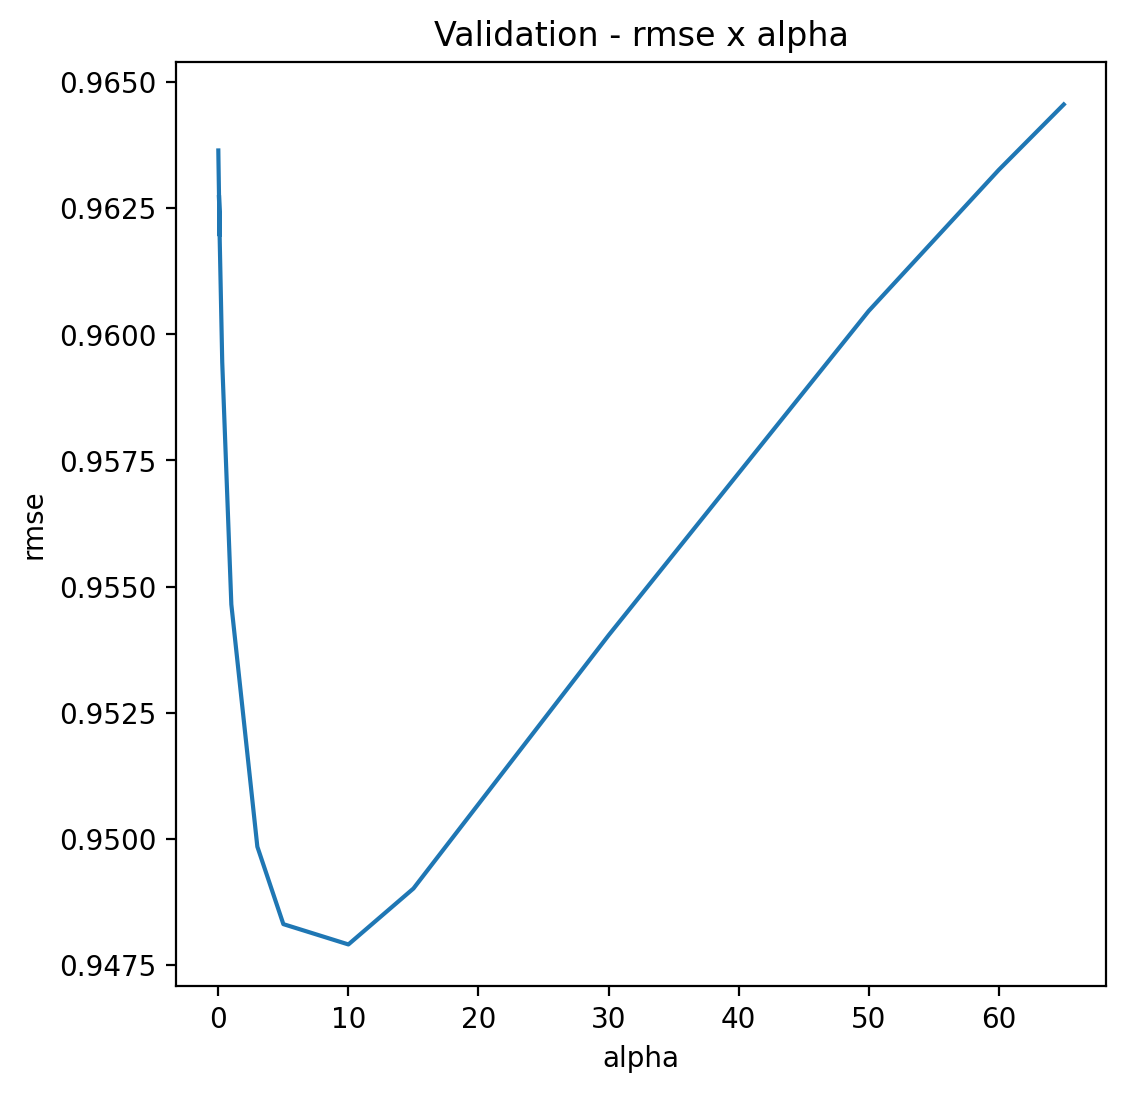

In [162]:
cv_ridge = pd.Series(cv_rmse_ridge, index = alphas)
cv_ridge.plot(title = "Validation - rmse x alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [163]:
print("rmse Ridge: {}".format(cv_ridge.min()))

rmse Ridge: 0.9479115249847101


In [164]:
# alpha com o menor rmse
cv_ridge.index[[cv_ridge.values == cv_ridge.min()]]

c:\users\gisel\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Float64Index([10.0], dtype='float64')

In [165]:
model_ridge = Ridge(alpha=10)
model_ridge.fit(X_train, y_train)

Ridge(alpha=10)

In [166]:
y_pred_ridge = model_ridge.predict(X_test)

In [167]:
model_ridge.score(X_train, y_train)
print("Ridge - Coefficient of determination(R^2) no treino: {}".format(model_ridge.score(X_train, y_train)))

Ridge - Coefficient of determination(R^2) no treino: 0.7810618868437469


In [168]:
model_ridge.score(X_test, y_test)
print("Ridge - Coefficient of determination(R^2) no teste: {}".format(model_ridge.score(X_train, y_train)))

Ridge - Coefficient of determination(R^2) no teste: 0.7810618868437469


In [169]:
rmse = -cross_val_score(model_ridge, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
print("Ridge - RMSE - Cross validation - no treino: {} ".format(rmse.mean()))

Ridge - RMSE - Cross validation - no treino: 0.8986704150078968 


In [170]:
rmse = -cross_val_score(model_ridge, X_test, y_test, scoring = "neg_mean_squared_error", cv = 5 )
print("Ridge - RMSE - Cross validation - no teste: {} ".format(rmse.mean()))

Ridge - RMSE - Cross validation - no teste: 1.0636430434697508 


#### Ridge Coeficientes 

In [171]:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " +  str(sum(coef_ridge == 0)) + " variables")

Ridge picked 227 variables and eliminated the other 33 variables


Text(0.5, 1.0, 'Coefficients in the Ridge Model')

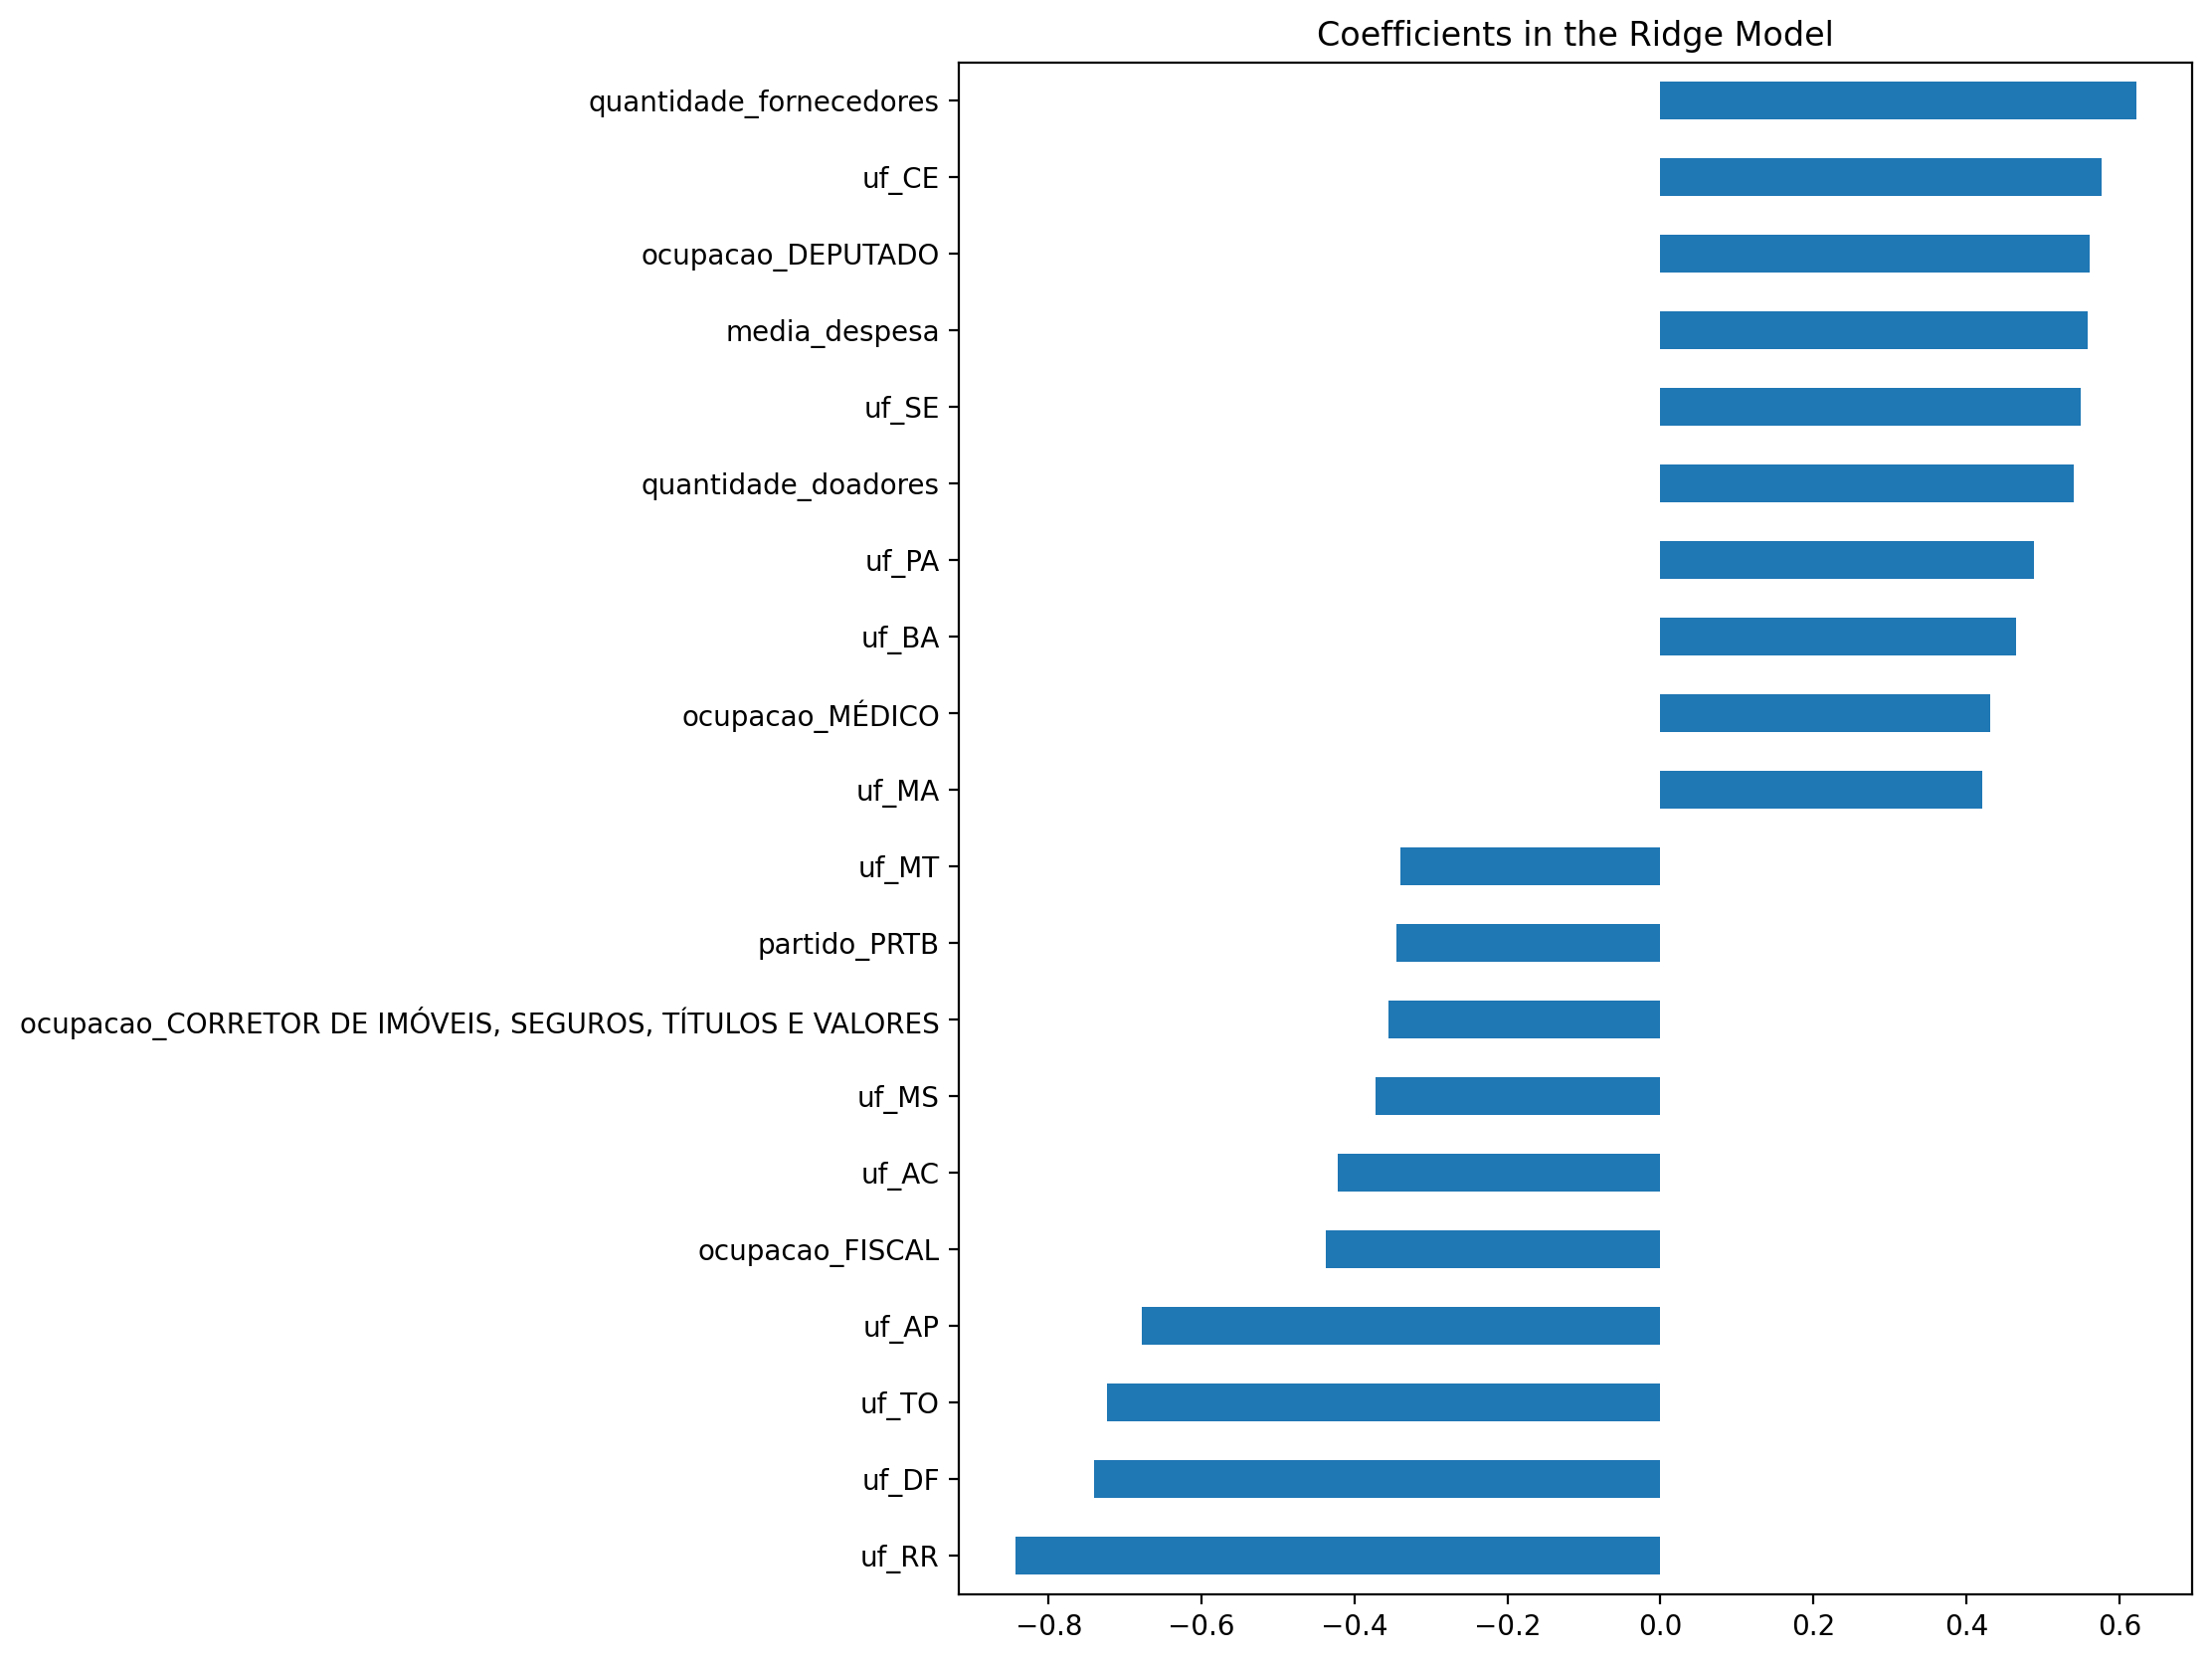

In [172]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:title={'center':'Ridge - residuals x preds'}, xlabel='preds', ylabel='residuals'>

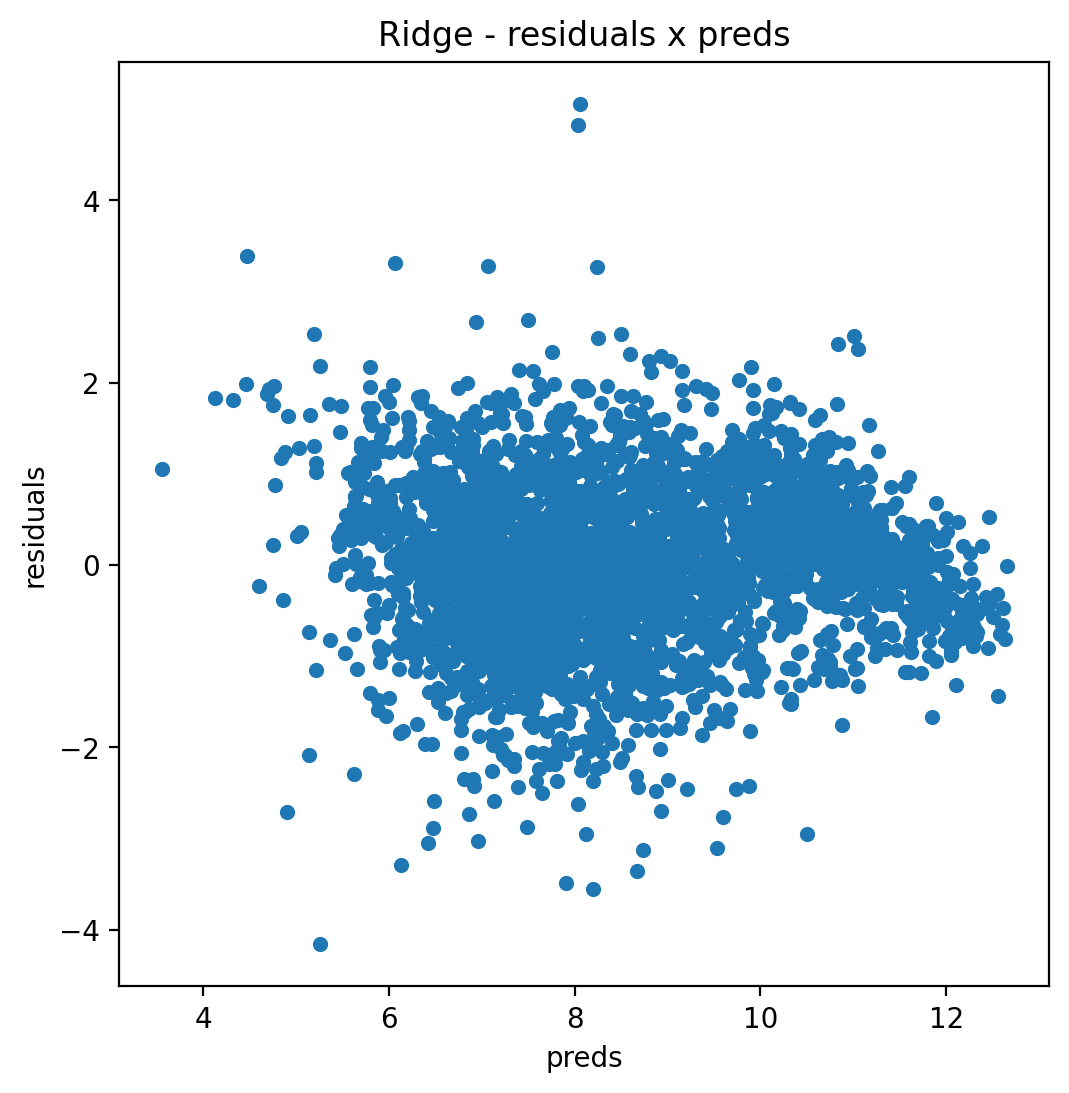

In [173]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", title = "Ridge - residuals x preds")

### 2 Modelo: Lassso 

In [174]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=60000000).fit(X_train, y_train)

In [175]:
print("Lasso - Coefficient of determination(R^2) no treino: {}".format(model_lasso.score(X_train, y_train)))

Lasso - Coefficient of determination(R^2) no treino: 0.7787787282262097


In [176]:
rmse = -cross_val_score(model_ridge, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
print("Lasso - RMSE - Cross validation - no treino: {} ".format(rmse.mean()))

Lasso - RMSE - Cross validation - no treino: 0.8986704150078968 


#### Lasso coeficient

In [177]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

In [178]:
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " + str(sum(coef_lasso == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 157 variables


In [179]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

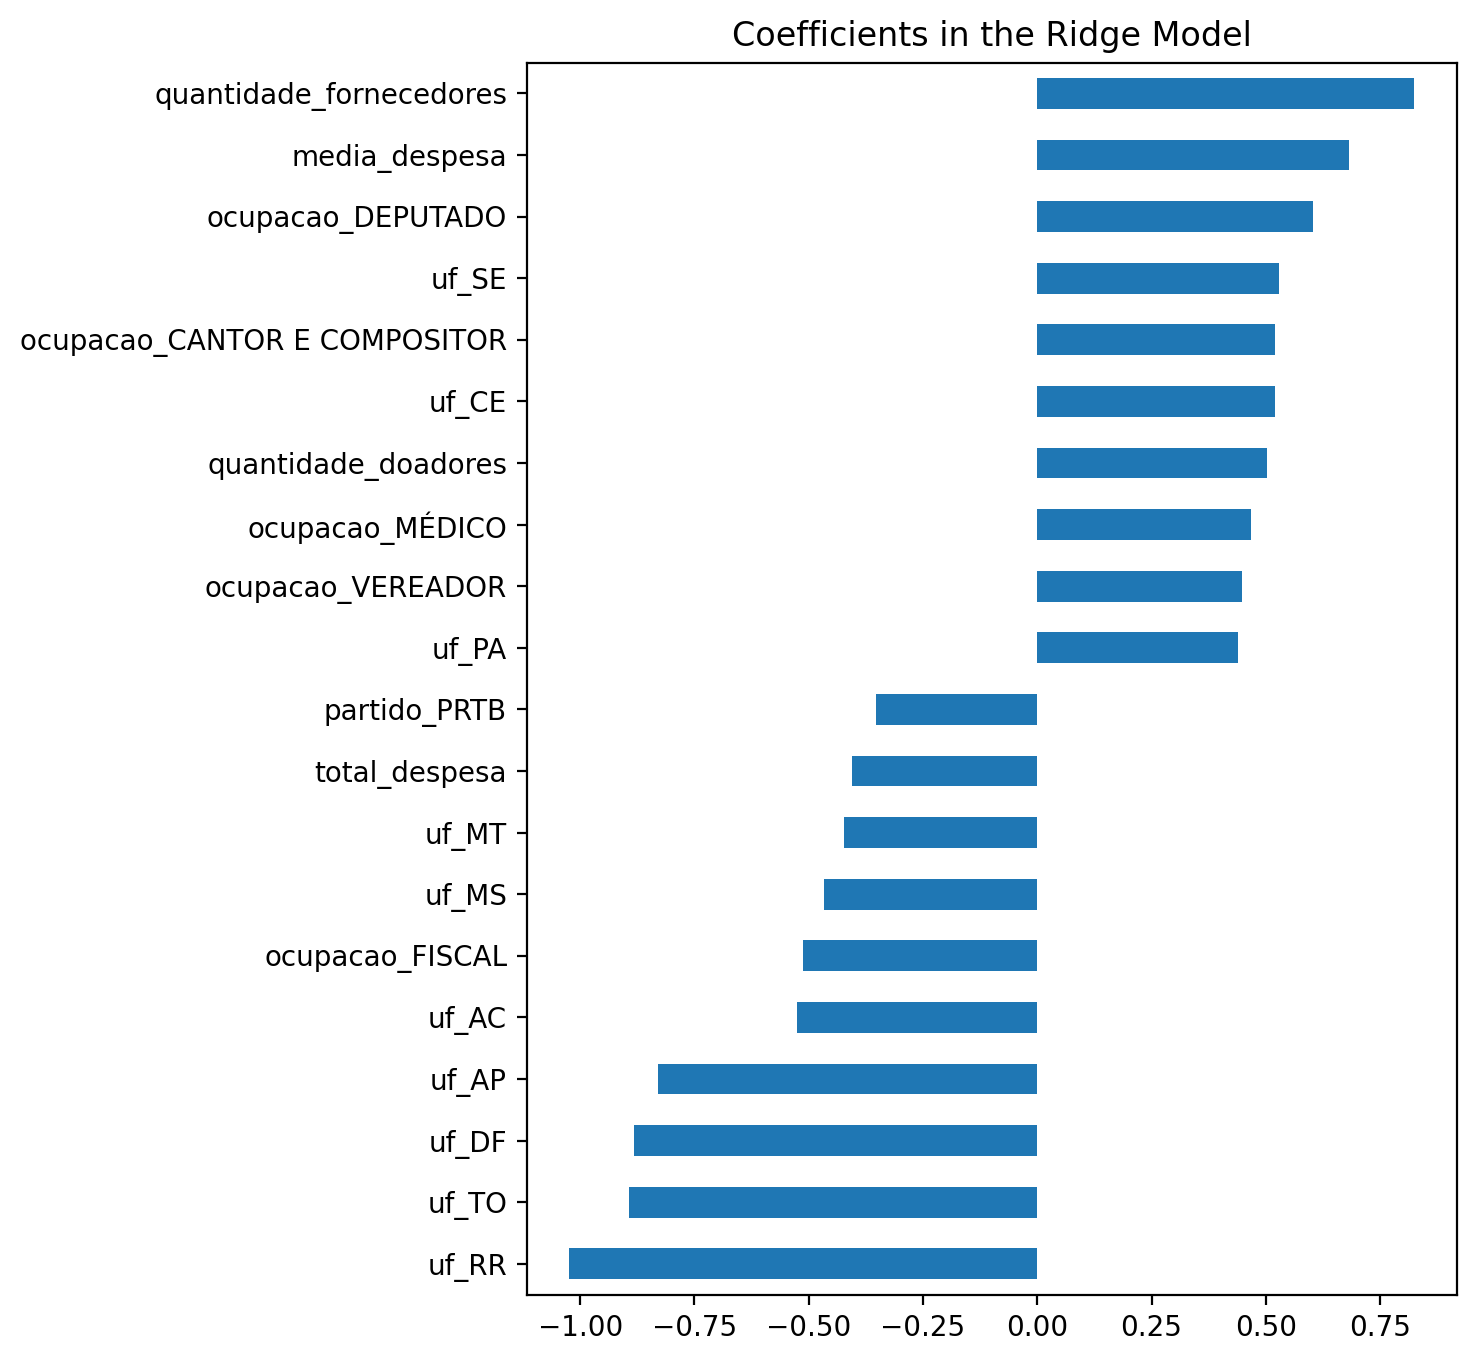

In [180]:
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:title={'center':'Ridge - residuals x preds'}, xlabel='preds', ylabel='residuals'>

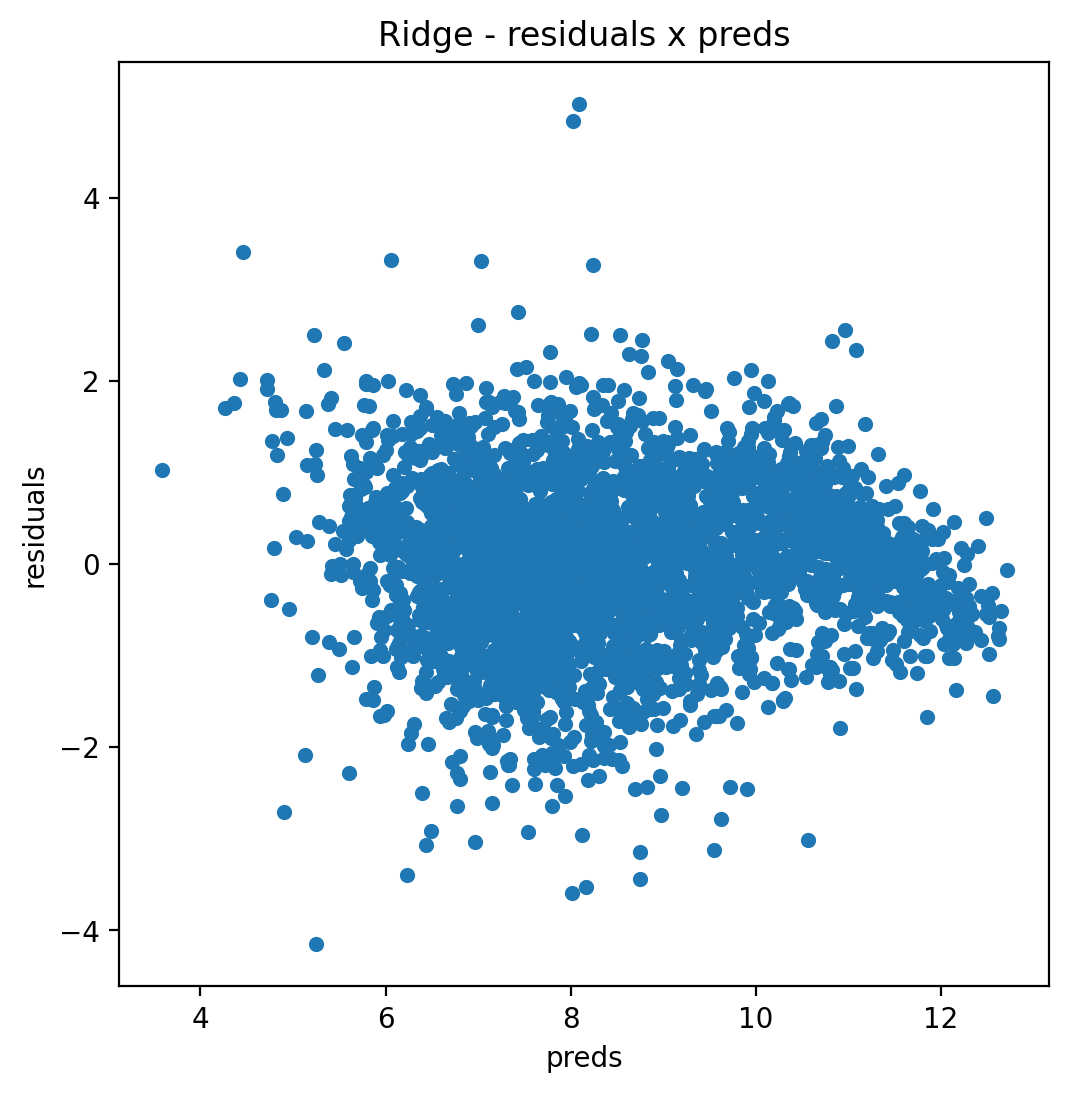

In [181]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", title = "Ridge - residuals x preds")

### Análise dos resultados Ridge e Lasso

O RMSE no modelo Ridge nos dados de treino foi de 0.78, enquanto que o RMSE no modelo Lasso nos dados de treino foi de 0.77.

### 3 Modelo: SVR

In [182]:
rmse_lista = []
c_lista = []
for i in range(1,10):
    model_svr = svm.SVR(kernel='rbf', C = i)
    model_svr.fit(X_train, y_train)
    score = model_svr.score(X_train, y_train)
    rmse_lista.append(model_svr.score(X_train, y_train))
    c_lista.append(i)
    
s = pd.Series(rmse_lista, index = c_lista)

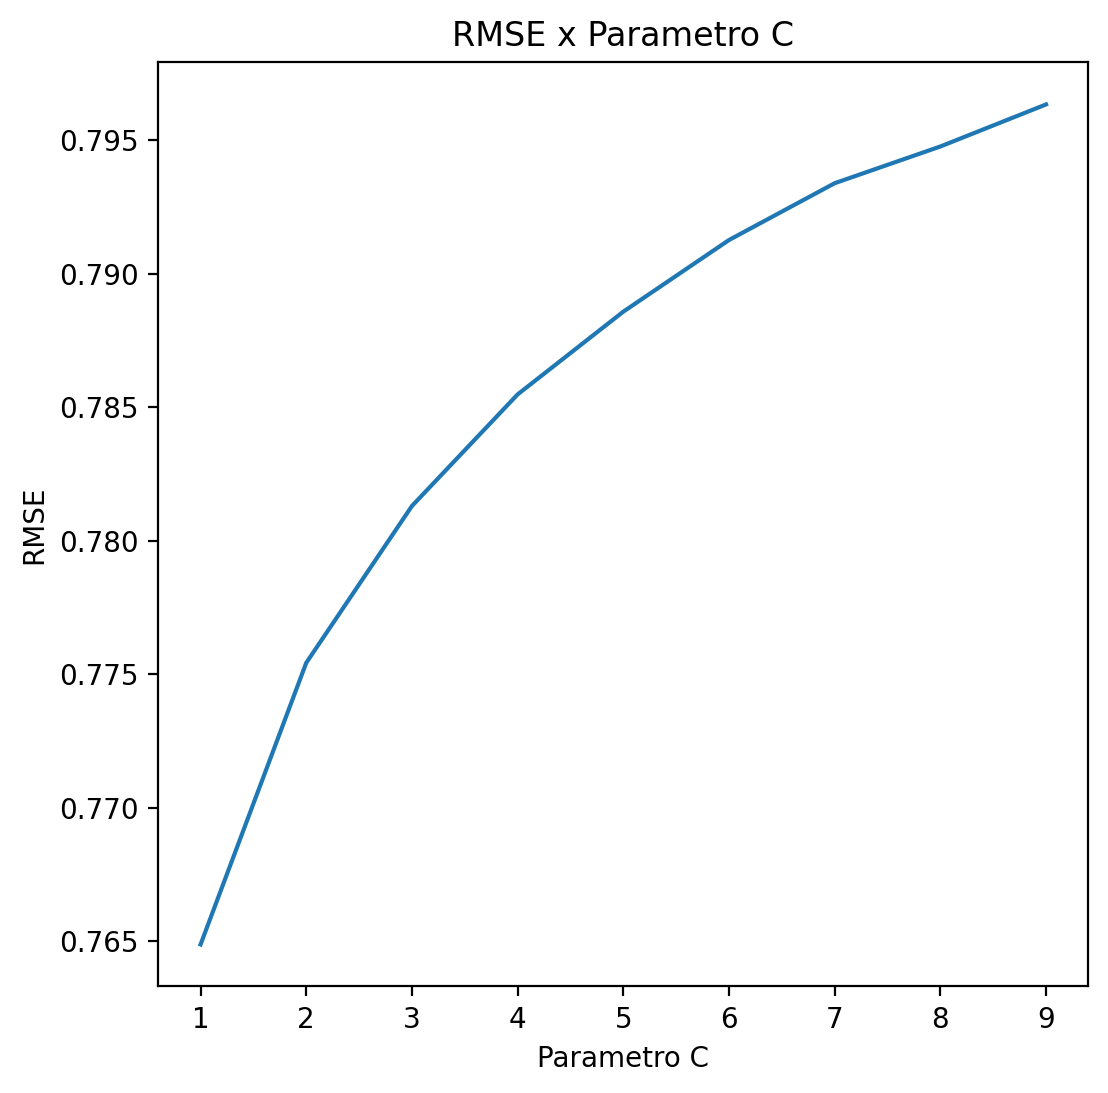

In [183]:
plt.xlabel("Parametro C")
plt.ylabel("RMSE")
plt.title("RMSE x Parametro C")
plt.plot(s.index, s.values)

O parâmetro C = 1 foi o que teve o menor RMSE no treino

In [184]:
def testar_kernels(kernels):
    for kernel in kernels:
        classifier = svm.SVR(kernel=kernel, C=1)
        cv_svr = rmse_cv(classifier, X_train, y_train).mean()
        print("SVR RMSE CROSS: {}".format(cv_svr))
        
#['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kernels = ['poly', 'rbf', 'sigmoid'] # o tempo de processamento do kernel linear é alto em relação aos demais
testar_kernels(kernels)

SVR RMSE CROSS: 0.9532183620452839
SVR RMSE CROSS: 0.9502583447300061
SVR RMSE CROSS: 10.378399316042254


O kernel rbf foi o que teve o menor RMSE no treino e o parâmetro c = 1

In [185]:
model_svr = svm.SVR(kernel='rbf', C = 1)
model_svr.fit(X_train, y_train)
rmse = model_svr.score(X_train, y_train)
print("SVR - RMSE - Treino: {}".format(rmse)) 

SVR - RMSE - Treino: 0.7648807211425839


In [186]:
y_pred_svr = model_svr.predict(X_test)

In [187]:
rmse = model_svr.score(X_test, y_test)
print("SVR - RMSE - Test: {}".format(rmse)) 

SVR - RMSE - Test: 0.6948067204019553


<AxesSubplot:title={'center':'SVR - Residuals x preds'}, xlabel='preds', ylabel='residuals'>

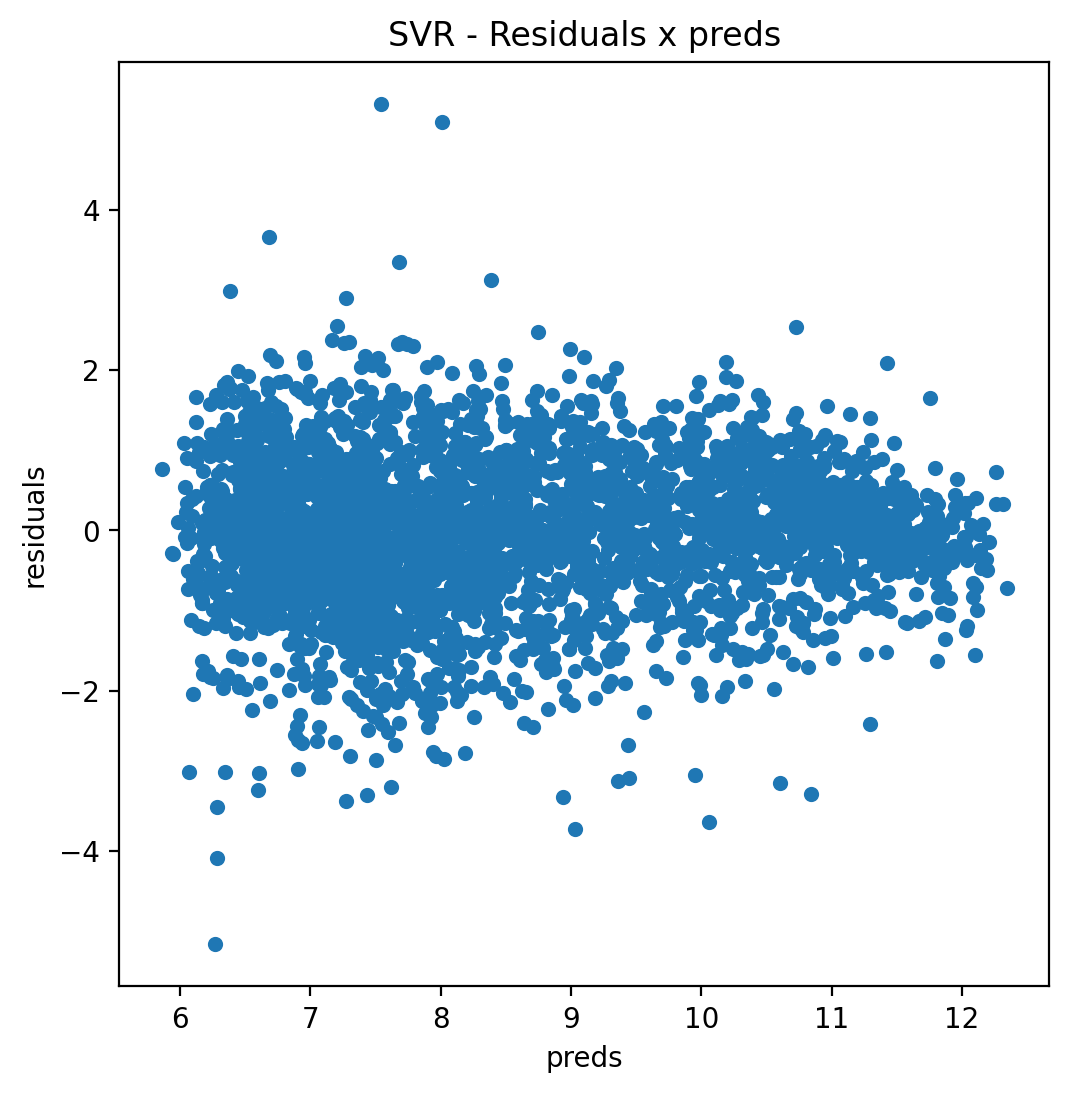

In [188]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_svr.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", title="SVR - Residuals x preds")

### Análise dos resultados SVR com Ridge e Lasso 

O RMSE no modelo Ridge nos dados de treino foi de 0.78, enquanto que o RMSE no modelo Lasso nos dados de treino foi de 0.77. Já o RMSE do SVM no treino foi de 0.76. Portanto o modelo do SVR levando em consideração somente o RMSE é o melhor modelo.

### 4 Modelo: RandomForestRegressor

In [189]:
model_random = RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)
model_random.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=43)

In [190]:
print("RandoForest - RMSE - Treino: {}".format(model_random.score(X_train, y_train)))

RandoForest - RMSE - Treino: 0.84654997803684


In [191]:
rmse = -cross_val_score(model_random, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
print("RandoForest - RMSE - Treino: {}".format(rmse.mean()))

RandoForest - RMSE - Treino: 0.891001969082511


In [192]:
y_pred_random = model_random.predict(X_test) 

<AxesSubplot:xlabel='preds', ylabel='residuals'>

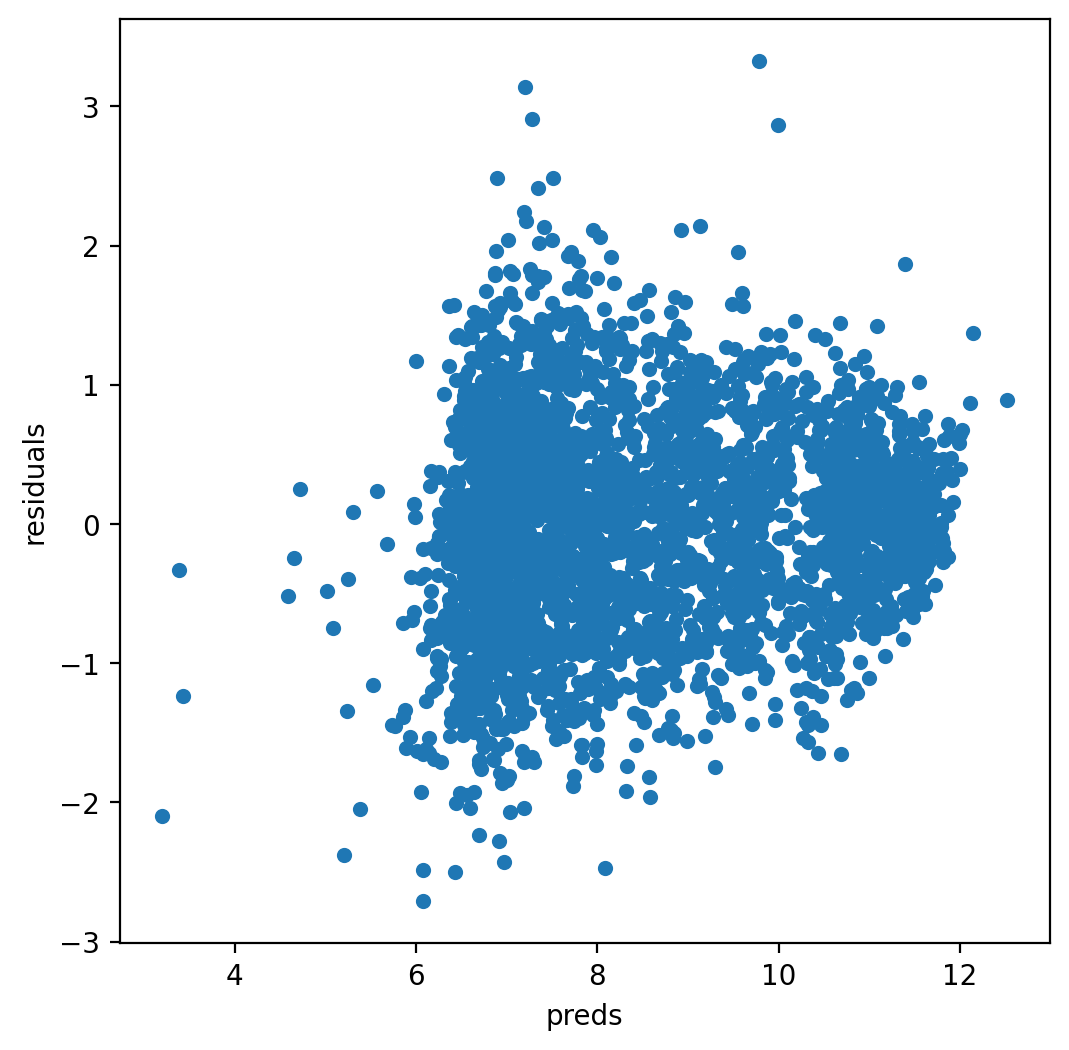

In [193]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_random.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### 5 Modelo: KNN 

In [194]:
model_knn = KNeighborsRegressor(n_neighbors=5)  
model_knn.fit(X_train, y_train)  

KNeighborsRegressor()

In [195]:
print("KNN - RSME - Treino: {} ".format(model_knn.score(X_train, y_train)))

KNN - RSME - Treino: 0.8146088779150541 


In [196]:
rmse = -cross_val_score(model_knn, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
print("KNN - RSME - Cross -Treino: {} ".format(rmse.mean()))

KNN - RSME - Cross -Treino: 1.069220342156861 


<AxesSubplot:xlabel='preds', ylabel='residuals'>

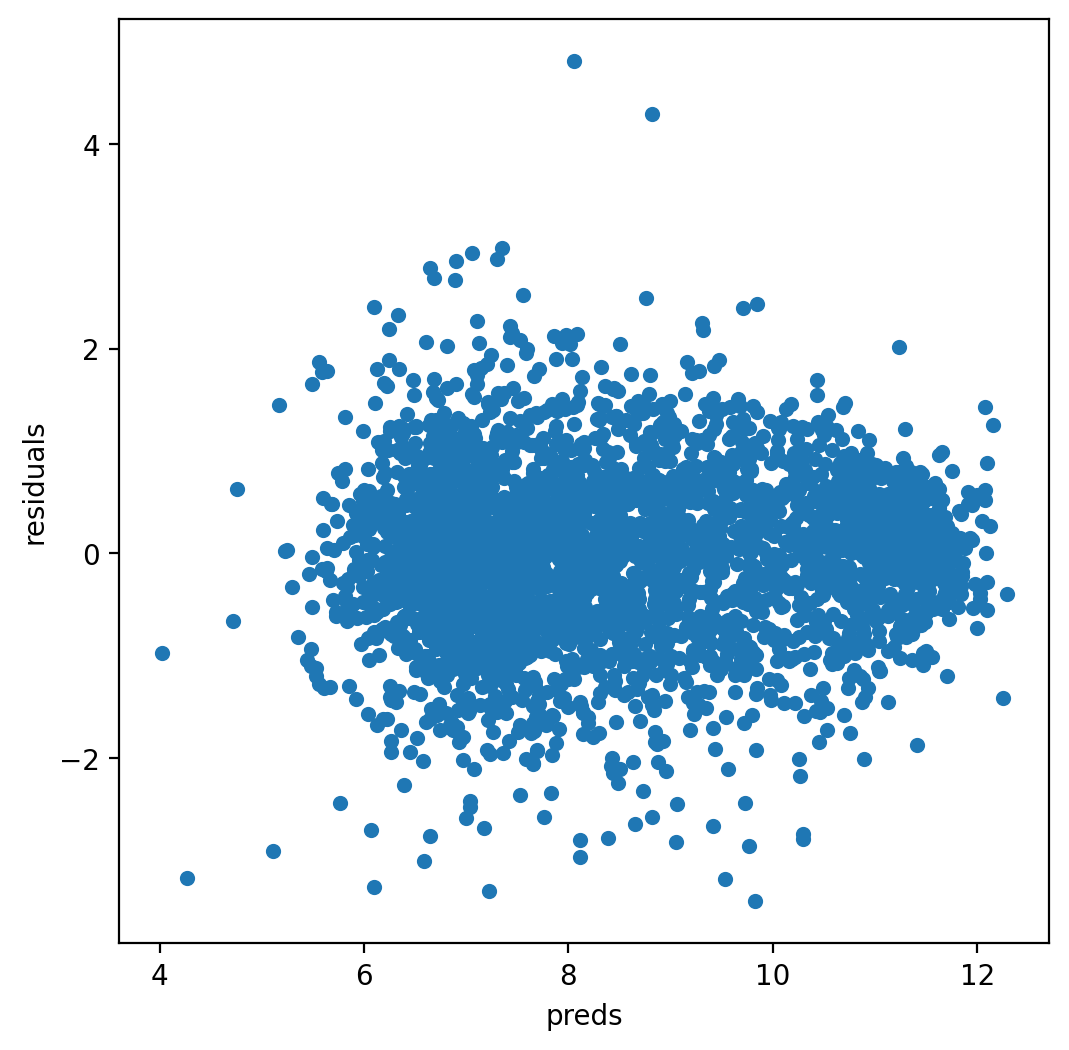

In [197]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_knn.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## Analise dos Resultados

Foram avaliados, 5 modelos: Ridge, Lasso, SVR, RandomForest, KNN
Respectivamente os RMSEs no treino foram (0.78, 0.77, 0.76, 0.84 e 0.81)
Portanto o melhor modelo, somente levando em consideração o RMSE é o SVR

# Re-treino do Modelo com todos os dados (2006 e 2010) e validação com 2014

In [198]:
model_svr = svm.SVR(kernel='rbf', C = 1)
model_svr.fit(X_train_tudo, y_train_tudo)

SVR(C=1)

In [199]:
print("RMSE melhor modelo - SVR: {}". format(model_svr.score(X_train_tudo, y_train_tudo)))

RMSE melhor modelo - SVR: 0.7712482372046037


In [216]:
y_pred_svr_model = model_svr.predict(X_test_2014)

ValueError: X.shape[1] = 245 should be equal to 260, the number of features at training time

## XGBOOST ( em construção )

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
predictions = predictions[(np.abs(stats.zscore(predictions)) < 3).all(axis=1)]
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"nome":test.index, "votos":preds})
solution.to_csv("saida.csv", index = False)